<a href="https://colab.research.google.com/github/AiJared/job_matching_model/blob/main/job_matching.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Cell 1: Import Libraries
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import os
import keras
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from keras.layers import Input, Dense, Dropout, BatchNormalization, Concatenate
from keras.models import Model
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# Check TensorFlow version
print(f"TensorFlow version: {tf.__version__}")

TensorFlow version: 2.18.0


In [5]:
# Load the dataset using pandas
df = pd.read_csv('D:/Projects/DJ/job_matching/website/job_matching/ai/job_matching_data.csv')

# Display structure and preview
print("Dataset Info:")
print(df.info())

print("\nSample of the dataset:")
print(df.head())

# Check for any missing values
print("\nMissing values count:")
print(df.isnull().sum())

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23088 entries, 0 to 23087
Data columns (total 20 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   job_id                     23088 non-null  object 
 1   candidate_id               23088 non-null  object 
 2   job_title                  23088 non-null  object 
 3   job_description            23088 non-null  object 
 4   job_required_skills        23088 non-null  object 
 5   job_level                  23088 non-null  object 
 6   job_location               23088 non-null  object 
 7   job_type                   23088 non-null  object 
 8   job_salary_range           23088 non-null  int64  
 9   job_education              23088 non-null  object 
 10  job_industry               23088 non-null  object 
 11  candidate_name             23088 non-null  object 
 12  candidate_skills           23088 non-null  object 
 13  candidate_experience       23088

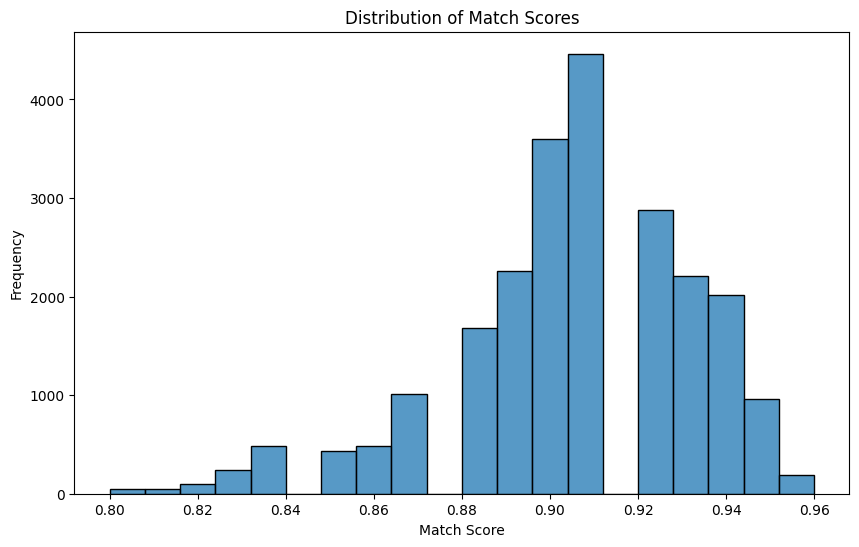

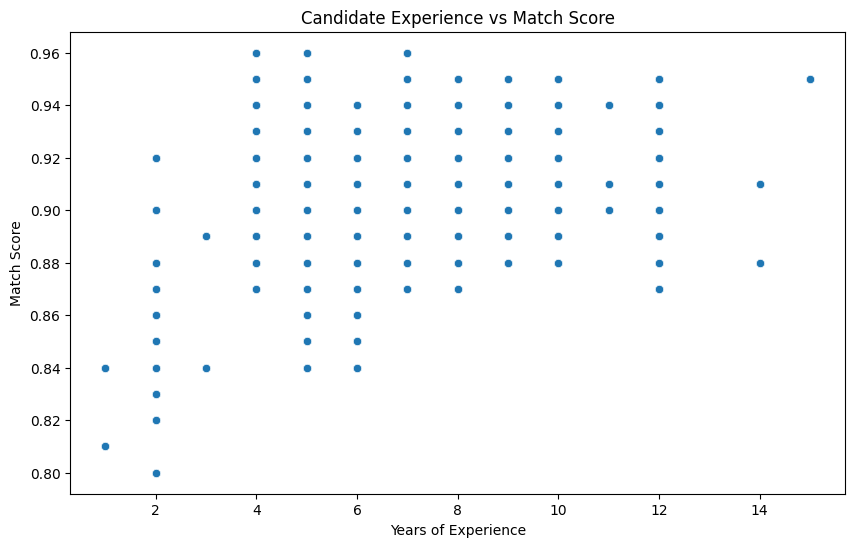

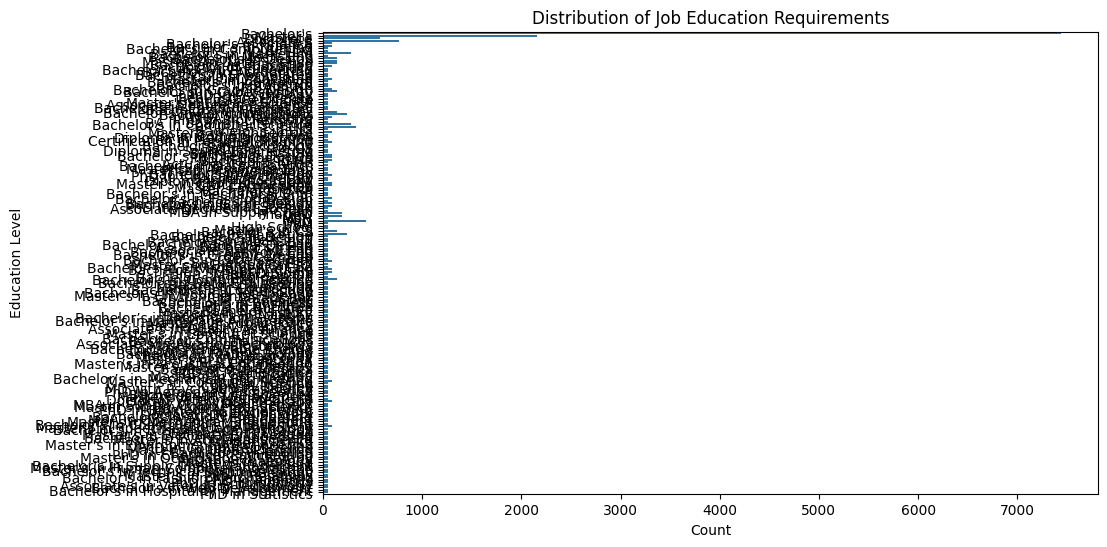

In [6]:
# Data Visualization
# Distribution of match scores
plt.figure(figsize=(10, 6))
sns.histplot(df['match_score'].astype(float), bins=20)
plt.title('Distribution of Match Scores')
plt.xlabel('Match Score')
plt.ylabel('Frequency')
plt.show()

# Experience vs match score
plt.figure(figsize=(10, 6))
sns.scatterplot(x=df['candidate_experience'].astype(float), y=df['match_score'].astype(float))
plt.title('Candidate Experience vs Match Score')
plt.xlabel('Years of Experience')
plt.ylabel('Match Score')
plt.show()

# Job education level distribution
plt.figure(figsize=(10, 6))
sns.countplot(y='job_education', data=df)
plt.title('Distribution of Job Education Requirements')
plt.xlabel('Count')
plt.ylabel('Education Level')
plt.show()

In [7]:
# Feature Engineering and Preprocessing
# Define preprocessing pipelines for different feature types

# Helper function to process salary information
def extract_salary(salary_str):
    try:
        return float(salary_str)
    except:
        return np.nan

# Convert categorical data to numeric and extract features
df['candidate_experience'] = df['candidate_experience'].astype(float)
df['availability_in_weeks'] = df['availability_in_weeks'].astype(float)
df['match_score'] = df['match_score'].astype(float)
df['job_salary_range'] = df['job_salary_range'].apply(extract_salary)
df['candidate_expected_salary'] = df['candidate_expected_salary'].apply(extract_salary)

# Create feature pipelines
def create_unified_preprocessor(df):
    # Define transformers for different feature types
    
    # Text features with TF-IDF
    job_desc_transformer = Pipeline([
        ('tfidf', TfidfVectorizer(max_features=100, stop_words='english'))
    ])
    
    job_title_transformer = Pipeline([
        ('tfidf', TfidfVectorizer(max_features=50, stop_words='english'))
    ])
    
    job_skills_transformer = Pipeline([
        ('tfidf', TfidfVectorizer(max_features=100, stop_words='english'))
    ])
    
    candidate_skills_transformer = Pipeline([
        ('tfidf', TfidfVectorizer(max_features=100, stop_words='english'))
    ])
    
    # Categorical features with one-hot encoding
    categorical_transformer = Pipeline([
        ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ])
    
    # Numeric features with standardization
    numeric_transformer = Pipeline([
        ('scaler', StandardScaler())
    ])
    
    # Define the preprocessor that combines all transformers
    preprocessor = ColumnTransformer(
        transformers=[
            # Job text features
            ('job_title', job_title_transformer, 'job_title'),
            ('job_desc', job_desc_transformer, 'job_description'),
            ('job_skills', job_skills_transformer, 'job_required_skills'),
            
            # Candidate text features
            ('candidate_skills', candidate_skills_transformer, 'candidate_skills'),
            
            # Categorical features
            ('job_categorical', categorical_transformer, 
             ['job_level', 'job_location', 'job_type', 'job_education', 'job_industry']),
            ('candidate_categorical', categorical_transformer, 
             ['candidate_education', 'candidate_location', 'candidate_preference']),
            
            # Numeric features
            ('numeric', numeric_transformer, 
             ['candidate_experience', 'job_salary_range', 'candidate_expected_salary', 'availability_in_weeks'])
        ],
        remainder='drop'  # Drop columns not explicitly mentioned
    )
    
    return preprocessor

# Create and fit the preprocessor
preprocessor = create_unified_preprocessor(df)
print("Fitting preprocessor...")
X_preprocessed = preprocessor.fit_transform(df)
print(f"Preprocessed feature shape: {X_preprocessed.shape}")

# Save the shape information for the model architecture
feature_dim = X_preprocessed.shape[1]

Fitting preprocessor...
Preprocessed feature shape: (23088, 992)


In [8]:
# Train-Test Split
# Get the target variable
y = df['match_score'].values

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X_preprocessed, y, test_size=0.2, random_state=42
)

print(f"Training samples: {X_train.shape[0]}")
print(f"Testing samples: {X_test.shape[0]}")

Training samples: 18470
Testing samples: 4618


In [9]:
# Cell 6: Build the Neural Network Model
# Custom serializable layer for later loading
@tf.keras.utils.register_keras_serializable()
class GradientReversalLayer(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(GradientReversalLayer, self).__init__(**kwargs)
        
    def call(self, inputs):
        return inputs
    
    def get_config(self):
        config = super(GradientReversalLayer, self).get_config()
        return config

def create_job_matching_model(input_dim):
    """Create a neural network model for job matching"""
    # Input layer
    inputs = Input(shape=(input_dim,), name="features_input")
    
    # Hidden layers with dropouts and batch normalization for regularization
    x = Dense(256, activation='relu')(inputs)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    
    x = Dense(128, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.2)(x)
    
    x = Dense(64, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.1)(x)
    
    # Output layer - regression for match score (0-1)
    outputs = Dense(1, activation='sigmoid', name='match_score')(x)
    
    # Create and compile model
    model = Model(inputs=inputs, outputs=outputs, name="job_matching_model")
    
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss='mean_squared_error',
        metrics=['mae', 'mse']
    )
    
    return model

# Create the model
model = create_job_matching_model(feature_dim)
print("Model Summary:")
model.summary()

Model Summary:


Model: "job_matching_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ features_input (InputLayer)     │ (None, 992)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       254,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ match_score (Dense)             │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 297,217 (1.13 MB)

 Trainable params: 296,321 (1.13 MB)

 Non-trainable params: 896 (3.50 KB)

In [10]:
# Train the Model
# Define callbacks for training
callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=3,
        verbose=1
    ),
    ModelCheckpoint(
        filepath='best_job_matching_model.keras',
        monitor='val_loss',
        save_best_only=True,
        verbose=1
    )
]

# Train the model
history = model.fit(
    X_train, y_train,
    validation_split=0.2,  # Further split training data for validation
    batch_size=16,
    epochs=50,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/50
923/924 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0656 - mae: 0.1713 - mse: 0.0656
Epoch 1: val_loss improved from inf to 0.00109, saving model to best_job_matching_model.keras
924/924 ━━━━━━━━━━━━━━━━━━━━ 32s 17ms/step - loss: 0.0655 - mae: 0.1711 - mse: 0.0655 - val_loss: 0.0011 - val_mae: 0.0264 - val_mse: 0.0011 - learning_rate: 0.0010
Epoch 2/50
923/924 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0026 - mae: 0.0404 - mse: 0.0026
Epoch 2: val_loss improved from 0.00109 to 0.00048, saving model to best_job_matching_model.keras
924/924 ━━━━━━━━━━━━━━━━━━━━ 15s 16ms/step - loss: 0.0026 - mae: 0.0404 - mse: 0.0026 - val_loss: 4.8048e-04 - val_mae: 0.0167 - val_mse: 4.8048e-04 - learning_rate: 0.0010
Epoch 3/50
922/924 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0015 - mae: 0.0301 - mse: 0.0015
Epoch 3: val_loss improved from 0.00048 to 0.00020, saving model to best_job_matching_model.keras
924/924 ━━━━━━━━━━━━━━━━━━━━ 17s 18ms/step - loss: 0.0015 - mae: 0.0301 - mse: 0.001

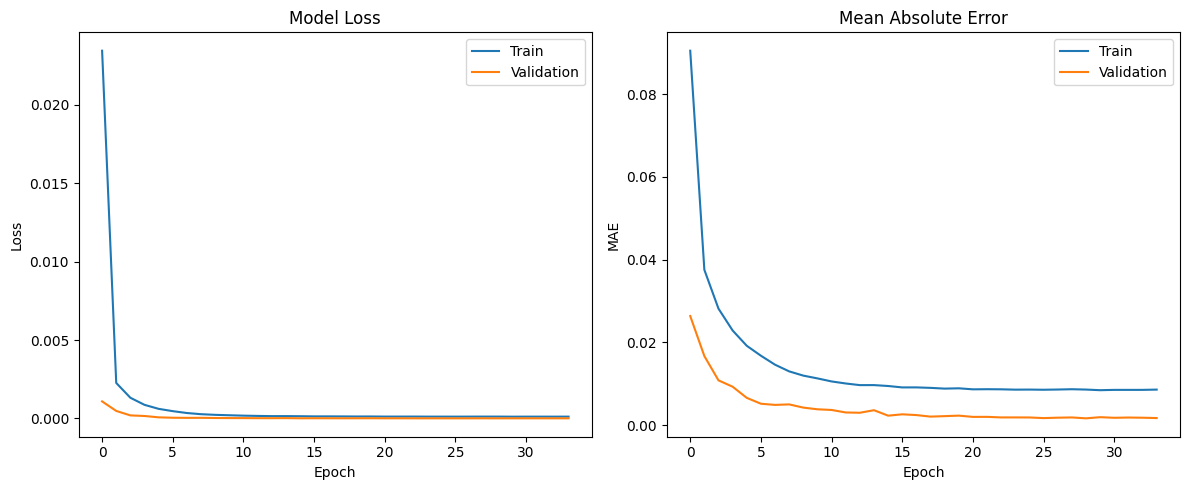

145/145 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 6.6296e-06 - mae: 0.0016 - mse: 6.6296e-06
Test Loss (MSE): 0.0000
Test MAE: 0.0016
145/145 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step


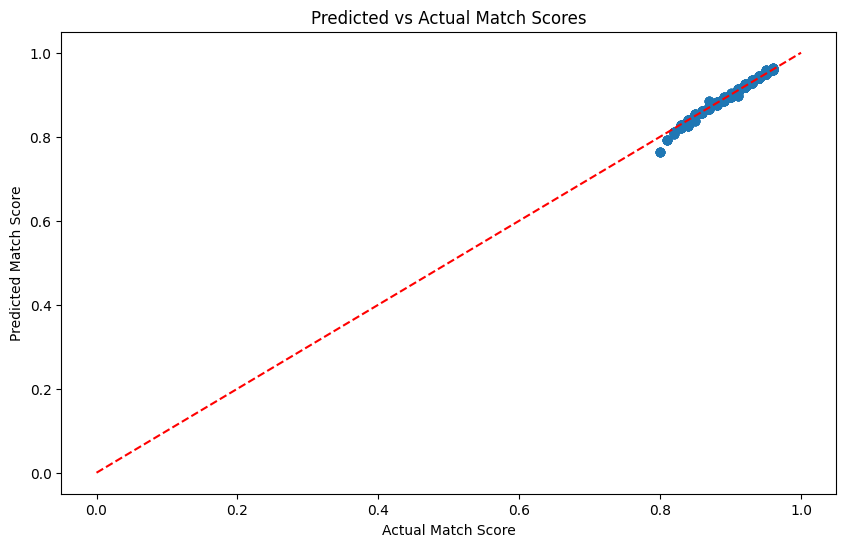

In [11]:
# Evaluate Model Performance
# Plot training history
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')

plt.subplot(1, 2, 2)
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('Mean Absolute Error')
plt.ylabel('MAE')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')

plt.tight_layout()
plt.show()

# Evaluate on test set
test_results = model.evaluate(X_test, y_test, verbose=1)
print(f"Test Loss (MSE): {test_results[0]:.4f}")
print(f"Test MAE: {test_results[1]:.4f}")

# Compare predictions vs actual
y_pred = model.predict(X_test)
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred)
plt.plot([0, 1], [0, 1], 'r--')
plt.xlabel('Actual Match Score')
plt.ylabel('Predicted Match Score')
plt.title('Predicted vs Actual Match Scores')
plt.show()

In [12]:
# Make Predictions and Save Model
# Function to make predictions for new job-candidate pairs
def predict_match(new_data, preprocessor, model):
    """Predict match score for new job-candidate data"""
    # Preprocess the data
    processed_data = preprocessor.transform(new_data)
    
    # Make prediction
    prediction = model.predict(processed_data)
    
    return prediction[0][0]  # Return the score

# Example prediction with the first sample
example_data = df.iloc[[0]]
example_score = predict_match(example_data, preprocessor, model)
print(f"Example prediction for {example_data['job_title'].values[0]} and {example_data['candidate_name'].values[0]}: {example_score:.4f}")
print(f"Actual match score: {example_data['match_score'].values[0]}")

# Define the save directory
SAVE_DIR = 'D:/Projects/DJ/job_matching/website/job_matching/ai'
os.makedirs(SAVE_DIR, exist_ok=True)

# Save the model in .keras format
model.save(os.path.join(SAVE_DIR, 'unified_matching_model.keras'))

# Save the preprocessor as .pkl
with open(os.path.join(SAVE_DIR, 'unified_preprocessor.pkl'), 'wb') as f:
    pickle.dump(preprocessor, f)

print(f"Model and preprocessor saved successfully in {SAVE_DIR} folder!")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 377ms/step
Example prediction for Software Engineer and Alex Johnson: 0.9507
Actual match score: 0.95
Model and preprocessor saved successfully in D:/Projects/DJ/job_matching/website/job_matching/ai folder!
